In [1]:
import copy
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from scipy import stats

pandarallel.initialize(progress_bar=True)

import BeamWithSprings as bm

import ajf_plts

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load result data

In [2]:
run_id = "LB_all_delta_w_damage.parquet"
locs = ["L", "R"]

full_res_df = pd.read_parquet(f"./{run_id}").loc[
    :,
    [
        "delta",
        "seq_month",
        "year",
        "month",
        "day",
        "hour",
        "minute",
        "dayofweek",
        "air_temperature",
        "AxleCount",
        "x_dam",
        "L",
        "R",
    ],
]

full_res_df.delta = full_res_df.delta.astype(float)
full_res_df.year = full_res_df.year.astype(int)
full_res_df = full_res_df.sort_values(["delta", "seq_month", "day", "hour", "minute"])

# Apply DH Random Sampling Algorithm

In [3]:
def get_DH_random_sample(target_prop = 0.1): 
    monitor_period = 60 * target_prop
    monitor_offset = np.random.uniform(0, 60-monitor_period, len(full_res_df))
    return full_res_df[(monitor_offset <= full_res_df.minute) & (full_res_df.minute < monitor_offset + monitor_period)]

DH_random_df = get_DH_random_sample()

In [4]:
axle_nums = [np.arange(2, 7), np.arange(5, 7), np.arange(6, 7)]
axle_names = ["All", "5ax", "6ax"]

baseline = full_res_df[(full_res_df.seq_month < 12) & (full_res_df.delta==0.0)]
#baseline = DH_random_df[(DH_random_df.seq_month < 12) & (DH_random_df.delta==0.0)]

def calc_emd(df):
    if df.year.min() == 0:
        return dict(
            zip(
                [l + "_" + n for n in axle_names for l in locs],
                [np.nan] * len(locs) * len(axle_names),
            )
        )
    elif len(df.seq_month.unique()) < 12:
        return dict(
            zip(
                [l + "_" + n for n in axle_names for l in locs],
                [np.nan] * len(locs) * len(axle_names),
            )
        )
    return dict(
        zip(
            [l + "_" + n for n in axle_names for l in locs],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in axle_nums
                for l in locs
            ],
        )
    )

In [6]:
emd_vals = get_DH_random_sample().groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_df = pd.DataFrame(
    emd_vals.to_list(),
    index=pd.MultiIndex.from_tuples(
        list(
            zip(
                emd_vals.index.get_level_values(0),
                emd_vals.index.get_level_values(1),
            )
        ),
        names=emd_vals.index.names,
    ),
)
emd_df = emd_df.sort_index()

In [41]:
emd_dfs = []
for _ in np.arange(20):
    emd_vals = get_DH_random_sample().groupby(["delta", "year"]).parallel_apply(calc_emd)
    emd_df = pd.DataFrame(
        emd_vals.to_list(),
        index=pd.MultiIndex.from_tuples(
            list(
                zip(
                    emd_vals.index.get_level_values(0),
                    emd_vals.index.get_level_values(1),
                )
            ),
            names=emd_vals.index.names,
        ),
    )
    emd_dfs.append(emd_df)
emd_df = pd.concat(emd_dfs)
emd_df = emd_df.sort_index()

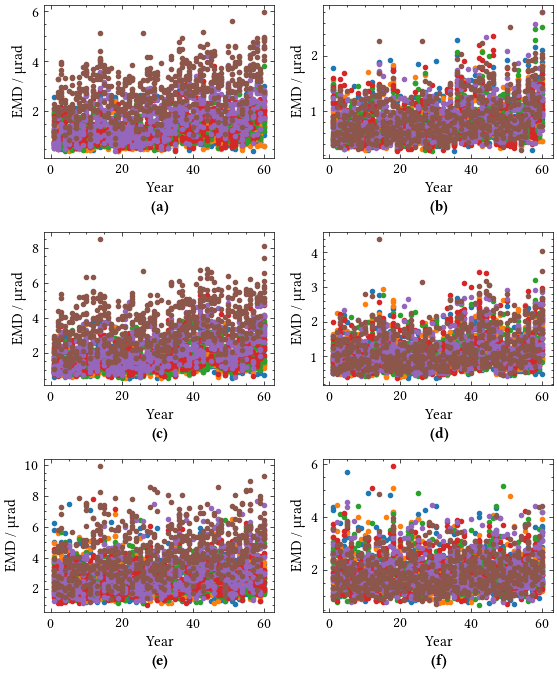

In [36]:
%matplotlib widget

fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches),
    ncols=2,
    nrows=3,
)
axes = axes.ravel()

for delta, group in emd_df.groupby("delta"):
    props = dict(ls="", marker=".")
    for ax, (row, emds) in zip(axes, group.T.iterrows()):
        ax.plot(emds.droplevel(0).index.values[1:], emds.values[1:] * 1e6, **props)

for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel(r"EMD / \unit{\micro\radian}")

ajf_plts.caption_axes(axes)
fig.tight_layout()

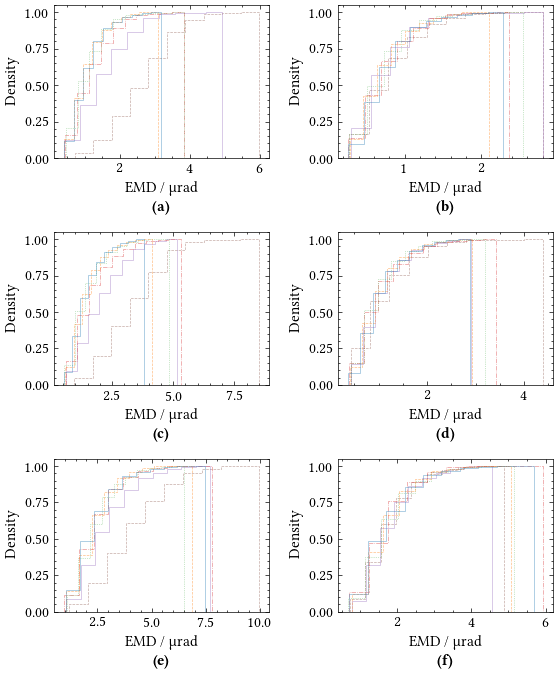

In [37]:
%matplotlib widget

fig, axes = plt.subplots(
    figsize=(ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches),
    ncols=2,
    nrows=3,
)
axes = axes.ravel()

for delta, group in emd_df.groupby("delta"):
    props = dict(density=True, histtype='step', cumulative=True, alpha=0.5, zorder=100 - 100 * delta)
    for ax, (row, emds) in zip(axes, group.T.iterrows()):
        ax.hist(emds.values[1:] * 1e6, **props)

for ax in axes:
    ax.set_xlabel(r"EMD / \unit{\micro\radian}")
    ax.set_ylabel(r"Density")

ajf_plts.caption_axes(axes)
fig.tight_layout()

In [38]:
emd_cols = [f"{l}_{n}" for n in axle_names for l in locs]
alpha=0.05

In [ ]:
for delta in DH_random_df.delta.unique():
    print(f"delta={delta:1.3f}")
    print(f"-----------")
    for col in emd_cols:
        p_vals = [stats.ks_2samp(
            df.loc[0.0, col].values,
            df.loc[delta, col].values,
            alternative="greater",  # describes CDF so greater means x < y as F(x) > F(y)
        ).pvalue for df in emd_dfs]
        res = stats.combine_pvalues(p_vals, method='stouffer')
        print(
            f"{col}: p={res[1]:0.3f} {'reject H0 (x=y) and accept H1 (x<y)' if res[1] < alpha else 'cannot reject H0 (x=y)'}"
        )
    
    print()

delta=0.000
-----------
L_All: p=1.000 cannot reject H0 (x=y)
R_All: p=1.000 cannot reject H0 (x=y)
L_5ax: p=1.000 cannot reject H0 (x=y)
R_5ax: p=1.000 cannot reject H0 (x=y)
L_6ax: p=1.000 cannot reject H0 (x=y)
R_6ax: p=1.000 cannot reject H0 (x=y)

delta=0.010
-----------
L_All: p=0.783 cannot reject H0 (x=y)
R_All: p=0.986 cannot reject H0 (x=y)
L_5ax: p=0.959 cannot reject H0 (x=y)
R_5ax: p=1.000 cannot reject H0 (x=y)
L_6ax: p=0.988 cannot reject H0 (x=y)
R_6ax: p=1.000 cannot reject H0 (x=y)

delta=0.025
-----------
L_All: p=0.016 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.636 cannot reject H0 (x=y)
L_5ax: p=0.010 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.750 cannot reject H0 (x=y)
L_6ax: p=0.596 cannot reject H0 (x=y)
R_6ax: p=0.941 cannot reject H0 (x=y)

delta=0.050
-----------
L_All: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.385 cannot reject H0 (x=y)
L_5ax: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.262 cannot reject H0 (x=y)
L_6ax: p=0.00

In [48]:
for delta in DH_random_df.delta.unique():
    print(f"delta={delta:1.3f}")
    print(f"-----------")
    for col in emd_cols:
        p_vals = [stats.ks_2samp(
            df.loc[0.0, col].values,
            df.loc[delta, col].values,
            alternative="greater",  # describes CDF so greater means x < y as F(x) > F(y)
        ).pvalue for df in emd_dfs[:]]
        res = stats.hmean(p_vals)
        print(
            f"{col}: p={res:0.3f} {'reject H0 (x=y) and accept H1 (x<y)' if res < alpha else 'cannot reject H0 (x=y)'}"
        )
    
    print()

delta=0.000
-----------
L_All: p=1.000 cannot reject H0 (x=y)
R_All: p=1.000 cannot reject H0 (x=y)
L_5ax: p=1.000 cannot reject H0 (x=y)
R_5ax: p=1.000 cannot reject H0 (x=y)
L_6ax: p=1.000 cannot reject H0 (x=y)
R_6ax: p=1.000 cannot reject H0 (x=y)

delta=0.010
-----------
L_All: p=0.303 cannot reject H0 (x=y)
R_All: p=0.381 cannot reject H0 (x=y)
L_5ax: p=0.430 cannot reject H0 (x=y)
R_5ax: p=0.541 cannot reject H0 (x=y)
L_6ax: p=0.476 cannot reject H0 (x=y)
R_6ax: p=0.386 cannot reject H0 (x=y)

delta=0.025
-----------
L_All: p=0.110 cannot reject H0 (x=y)
R_All: p=0.233 cannot reject H0 (x=y)
L_5ax: p=0.088 cannot reject H0 (x=y)
R_5ax: p=0.242 cannot reject H0 (x=y)
L_6ax: p=0.192 cannot reject H0 (x=y)
R_6ax: p=0.276 cannot reject H0 (x=y)

delta=0.050
-----------
L_All: p=0.010 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.285 cannot reject H0 (x=y)
L_5ax: p=0.021 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.200 cannot reject H0 (x=y)
L_6ax: p=0.084 cannot reject H0 (x=y)
R

# Apply AJF Random Sampling

In [54]:
def get_AJF_random_sample(target_prop = 0.1): 
    df = full_res_df.set_index(['seq_month', 'day', 'hour'])
    
    months = np.sort(full_res_df.seq_month.unique())
    days = np.sort(full_res_df.day.unique())
    hours = np.sort(full_res_df.hour.unique())

    ind = np.vstack([np.repeat(months, len(days) * len(hours)), np.tile(np.repeat(days, len(hours)), len(months)),  np.tile(hours, len(months) * len(days))]).T
    sample_ind = ind[np.random.uniform(0.0, 1.0, len(ind)) < target_prop]
    sample_ind = pd.MultiIndex.from_arrays(sample_ind.T, names=df.index.names)
    return df.loc[df.index.intersection(sample_ind)].reset_index()

start = time.time()
AJF_random_df = get_AJF_random_sample()
end = time.time()

print(end-start)

19.758313179016113


In [105]:
months = np.sort(full_res_df.seq_month.unique())
days = np.sort(full_res_df.day.unique())
hours = np.sort(full_res_df.hour.unique())

def get_AJF_random_sample(target_prop = 0.1): 
    ind = np.vstack([np.repeat(months, len(days) * len(hours)), np.tile(np.repeat(days, len(hours)), len(months)),  np.tile(hours, len(months) * len(days))]).T
    sample_ind = ind[np.random.uniform(0.0, 1.0, len(ind)) < target_prop]
    sample_ind = pd.MultiIndex.from_arrays(sample_ind.T, names=df.index.names)
    sample_codes = sample_ind.get_level_values(0) * 1000 + (sample_ind.get_level_values(1) * 24 + sample_ind.get_level_values(2))
    full_codes = full_res_df.seq_month * 1000 + (full_res_df.day * 24 + full_res_df.hour)
    return full_res_df.loc[full_codes.isin(sample_codes)]

AJF_random_df = get_AJF_random_sample()

0.5209641456604004


In [106]:
emd_dfs = []
for _ in np.arange(10):
    emd_vals = get_AJF_random_sample().groupby(["delta", "year"]).parallel_apply(calc_emd)
    emd_df = pd.DataFrame(
        emd_vals.to_list(),
        index=pd.MultiIndex.from_tuples(
            list(
                zip(
                    emd_vals.index.get_level_values(0),
                    emd_vals.index.get_level_values(1),
                )
            ),
            names=emd_vals.index.names,
        ),
    )
    emd_dfs.append(emd_df)
emd_df = pd.concat(emd_dfs)
emd_df = emd_df.sort_index()

In [107]:
emd_cols = [f"{l}_{n}" for n in axle_names for l in locs]
alpha=0.05

In [108]:
for delta in DH_random_df.delta.unique():
    print(f"delta={delta:1.3f}")
    print(f"-----------")
    for col in emd_cols:
        p_vals = [stats.ks_2samp(
            df.loc[0.0, col].values,
            df.loc[delta, col].values,
            alternative="greater",  # describes CDF so greater means x < y as F(x) > F(y)
        ).pvalue for df in emd_dfs]
        res = stats.combine_pvalues(p_vals, method='stouffer')
        print(
            f"{col}: p={res[1]:0.3f} {'reject H0 (x=y) and accept H1 (x<y)' if res[1] < alpha else 'cannot reject H0 (x=y)'}"
        )
    
    print()

delta=0.000
-----------
L_All: p=1.000 cannot reject H0 (x=y)
R_All: p=1.000 cannot reject H0 (x=y)
L_5ax: p=1.000 cannot reject H0 (x=y)
R_5ax: p=1.000 cannot reject H0 (x=y)
L_6ax: p=1.000 cannot reject H0 (x=y)
R_6ax: p=1.000 cannot reject H0 (x=y)

delta=0.010
-----------
L_All: p=0.869 cannot reject H0 (x=y)
R_All: p=0.996 cannot reject H0 (x=y)
L_5ax: p=0.920 cannot reject H0 (x=y)
R_5ax: p=0.994 cannot reject H0 (x=y)
L_6ax: p=0.947 cannot reject H0 (x=y)
R_6ax: p=0.996 cannot reject H0 (x=y)

delta=0.025
-----------
L_All: p=0.096 cannot reject H0 (x=y)
R_All: p=0.970 cannot reject H0 (x=y)
L_5ax: p=0.252 cannot reject H0 (x=y)
R_5ax: p=0.951 cannot reject H0 (x=y)
L_6ax: p=0.690 cannot reject H0 (x=y)
R_6ax: p=0.970 cannot reject H0 (x=y)

delta=0.050
-----------
L_All: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.917 cannot reject H0 (x=y)
L_5ax: p=0.000 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.804 cannot reject H0 (x=y)
L_6ax: p=0.027 reject H0 (x=y) and acce

In [109]:
for delta in DH_random_df.delta.unique():
    print(f"delta={delta:1.3f}")
    print(f"-----------")
    for col in emd_cols:
        p_vals = [stats.ks_2samp(
            df.loc[0.0, col].values,
            df.loc[delta, col].values,
            alternative="greater",  # describes CDF so greater means x < y as F(x) > F(y)
        ).pvalue for df in emd_dfs[:]]
        res = stats.hmean(p_vals)
        print(
            f"{col}: p={res:0.3f} {'reject H0 (x=y) and accept H1 (x<y)' if res < alpha else 'cannot reject H0 (x=y)'}"
        )
    
    print()

delta=0.000
-----------
L_All: p=1.000 cannot reject H0 (x=y)
R_All: p=1.000 cannot reject H0 (x=y)
L_5ax: p=1.000 cannot reject H0 (x=y)
R_5ax: p=1.000 cannot reject H0 (x=y)
L_6ax: p=1.000 cannot reject H0 (x=y)
R_6ax: p=1.000 cannot reject H0 (x=y)

delta=0.010
-----------
L_All: p=0.601 cannot reject H0 (x=y)
R_All: p=0.797 cannot reject H0 (x=y)
L_5ax: p=0.642 cannot reject H0 (x=y)
R_5ax: p=0.746 cannot reject H0 (x=y)
L_6ax: p=0.656 cannot reject H0 (x=y)
R_6ax: p=0.777 cannot reject H0 (x=y)

delta=0.025
-----------
L_All: p=0.275 cannot reject H0 (x=y)
R_All: p=0.696 cannot reject H0 (x=y)
L_5ax: p=0.363 cannot reject H0 (x=y)
R_5ax: p=0.690 cannot reject H0 (x=y)
L_6ax: p=0.524 cannot reject H0 (x=y)
R_6ax: p=0.702 cannot reject H0 (x=y)

delta=0.050
-----------
L_All: p=0.046 reject H0 (x=y) and accept H1 (x<y)
R_All: p=0.648 cannot reject H0 (x=y)
L_5ax: p=0.038 reject H0 (x=y) and accept H1 (x<y)
R_5ax: p=0.554 cannot reject H0 (x=y)
L_6ax: p=0.208 cannot reject H0 (x=y)
R